In [2]:
# 📂 Instructions: 
# ⚠️ Please change the file paths below to the location where your files are stored or to be stored.

# 📦 Imports
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
import statsmodels.api as sm
from rdkit.Chem import AllChem, DataStructs
from rdkit.ML.Cluster import Butina
import warnings
warnings.filterwarnings('ignore')

# ========== SECTION 1: Load & Clean Data ==========
file_path = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\2\\ML 2.csv"
df = pd.read_csv(file_path)
df = df[['Molecule ChEMBL ID', 'Smiles', 'pChEMBL Value']].copy()
df.dropna(subset=['pChEMBL Value'], inplace=True)
df['Smiles'] = df['Smiles'].astype(str)
initial_shape = df.shape
df = df.sort_values('pChEMBL Value', ascending=False).drop_duplicates(subset='Smiles', keep='first')
print(f"🧹 Removed {initial_shape[0] - df.shape[0]} duplicate SMILES. New shape: {df.shape}")

🧹 Removed 572 duplicate SMILES. New shape: (1997, 3)


In [4]:
# ========== SECTION 2: Descriptor Calculation ==========
descriptor_names_all = [name for name, _ in Descriptors.descList]
def compute_all_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [None] * len(descriptor_names_all)
        return [func(mol) for _, func in Descriptors.descList]
    except:
        return [None] * len(descriptor_names_all)

descriptor_values_all = df['Smiles'].apply(compute_all_descriptors)
descriptor_df_all = pd.DataFrame(descriptor_values_all.tolist(), columns=descriptor_names_all)
df_full = pd.concat([df.reset_index(drop=True), descriptor_df_all], axis=1)
df_full.dropna(inplace=True)
print(f"✅ Final cleaned dataset: {df_full.shape}")

[08:52:28] SMILES Parse Error: syntax error while parsing: nan
[08:52:28] SMILES Parse Error: check for mistakes around position 2:
[08:52:28] nan
[08:52:28] ~^
[08:52:28] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'


✅ Final cleaned dataset: (1995, 220)


In [6]:
# ========== SECTION 3: Feature Filtering ==========
X_all = df_full[descriptor_names_all].copy()
y_all = df_full['pChEMBL Value']

# Remove constant descriptors
selector = VarianceThreshold(threshold=0.0)
X_nonconstant = pd.DataFrame(selector.fit_transform(X_all), columns=X_all.columns[selector.get_support()])
print(f"🧹 Removed {X_all.shape[1] - X_nonconstant.shape[1]} constant descriptors.")

# Remove highly correlated descriptors
corr_matrix = X_nonconstant.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.80)]
X_corr_filtered = X_nonconstant.drop(columns=to_drop_corr)
print(f"🔗 Removed {len(to_drop_corr)} highly correlated descriptors (r > 0.80).")
print(f"🔬 Remaining descriptors: {X_corr_filtered.shape[1]}")

🧹 Removed 16 constant descriptors.
🔗 Removed 66 highly correlated descriptors (r > 0.80).
🔬 Remaining descriptors: 135


In [8]:
# ========== SECTION 4: VIF Filtering ==========
def calculate_vif(X_df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    return vif_data

X_vif = X_corr_filtered.copy()
vif_dropped = []
vif_threshold = 5  # 🛡️ Stricter threshold for QSAR

print("🚦 Starting VIF filtering...")
while True:
    vif_df = calculate_vif(X_vif)
    max_vif = vif_df['VIF'].max()
    if max_vif > vif_threshold:
        drop_feature = vif_df.sort_values('VIF', ascending=False).iloc[0]['Feature']
        X_vif.drop(columns=[drop_feature], inplace=True)
        vif_dropped.append((drop_feature, round(max_vif, 2)))
        print(f"⚠️ Dropped: {drop_feature} (VIF={round(max_vif,2)}) — {X_vif.shape[1]} features remain")
    else:
        print(f"✅ All VIFs are acceptable (≤ {vif_threshold}).")
        break

if vif_dropped:
    print(f"\n📉 VIF Filter Summary — Dropped {len(vif_dropped)} descriptors:")
    for name, vif_val in vif_dropped:
        print(f"   - {name} (VIF={vif_val})")

print(f"\n📦 Final descriptor count after VIF: {X_vif.shape[1]}")


🚦 Starting VIF filtering...
⚠️ Dropped: Ipc (VIF=24.86) — 134 features remain
⚠️ Dropped: NumHeterocycles (VIF=inf) — 133 features remain
⚠️ Dropped: MolWt (VIF=48944.32) — 132 features remain
⚠️ Dropped: SMR_VSA7 (VIF=26871.17) — 131 features remain
⚠️ Dropped: MolLogP (VIF=4999.02) — 130 features remain
⚠️ Dropped: BCUT2D_CHGLO (VIF=4129.85) — 129 features remain
⚠️ Dropped: PEOE_VSA7 (VIF=3258.0) — 128 features remain
⚠️ Dropped: BCUT2D_CHGHI (VIF=2785.92) — 127 features remain
⚠️ Dropped: TPSA (VIF=2419.08) — 126 features remain
⚠️ Dropped: BCUT2D_MWLOW (VIF=2192.37) — 125 features remain
⚠️ Dropped: BCUT2D_LOGPLOW (VIF=1494.98) — 124 features remain
⚠️ Dropped: SMR_VSA10 (VIF=1125.9) — 123 features remain
⚠️ Dropped: NumAromaticRings (VIF=977.06) — 122 features remain
⚠️ Dropped: VSA_EState2 (VIF=858.53) — 121 features remain
⚠️ Dropped: MaxAbsEStateIndex (VIF=743.1) — 120 features remain
⚠️ Dropped: SMR_VSA1 (VIF=605.18) — 119 features remain
⚠️ Dropped: NHOHCount (VIF=549.01) — 


✅ Best descriptor count: 25 | R² = 0.4978, RMSE = 0.7716, MAE = 0.5977

📊 Publication-Ready Validation Metrics
—————————————————————————————————————————————
Internal Validation:
  R²: 0.9269
  Adjusted R²: 0.9256
  Q² (LOO): 0.4744
  RMSE (LOO): 0.8105
  CCC (Train): 0.9562

External Validation:
  R² (Test): 0.4978
  RMSE (Test): 0.7716
  CCC (Test): 0.6598
  k': 0.9869
  k: 0.9996

Y-Randomization:
  Mean R² (Random): -0.1234
  cR²p: 0.5592
  ✅ Model is statistically robust (cR²p > 0.5)


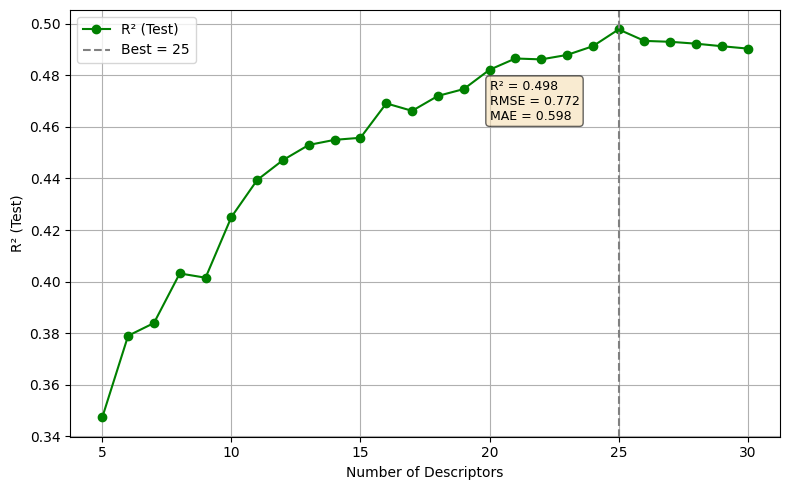

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

# === Utility functions ===
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

def concordance_cc(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    return (2 * cov) / (sd_true**2 + sd_pred**2 + (mean_true - mean_pred)**2)

def loo_q2(model, X, y):
    loo = LeaveOneOut()
    y_true, y_pred = [], []
    for train_idx, test_idx in loo.split(X):
        model.fit(X[train_idx], y.iloc[train_idx])
        y_pred.append(model.predict(X[test_idx])[0])
        y_true.append(y.iloc[test_idx].values[0])
    q2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return q2, rmse

# === SECTION 1: Feature Importance and Descriptor Count Selection ===
rf_initial = RandomForestRegressor(n_estimators=200, random_state=42)
rf_initial.fit(X_vif, y_all)
feature_importance = pd.Series(rf_initial.feature_importances_, index=X_vif.columns).sort_values(ascending=False)

metrics = []
descriptor_counts = range(5, min(30, len(feature_importance)) + 1)

for n in descriptor_counts:
    top_features = feature_importance.head(n).index.tolist()
    X_selected = X_vif[top_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_all, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred_test = model.predict(X_test_scaled)

    metrics.append({
        "n_descriptors": n,
        "R2_test": r2_score(y_test, y_pred_test),
        "RMSE_test": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "MAE_test": mean_absolute_error(y_test, y_pred_test)
    })

df_metrics = pd.DataFrame(metrics)

# === SECTION 2: Optimal Descriptor Count ===
best_row = df_metrics.sort_values(by="R2_test", ascending=False).iloc[0]
best_n = int(best_row["n_descriptors"])
print(f"\n✅ Best descriptor count: {best_n} | R² = {best_row['R2_test']:.4f}, RMSE = {best_row['RMSE_test']:.4f}, MAE = {best_row['MAE_test']:.4f}")
top_features_final = feature_importance.head(best_n).index.tolist()
X_final = X_vif[top_features_final]

# === SECTION 3: Final Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_final, y_all, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === SECTION 4: Model Training and Evaluation ===
final_model = RandomForestRegressor(n_estimators=200, random_state=42)
final_model.fit(X_train_scaled, y_train)
y_train_pred = final_model.predict(X_train_scaled)
y_test_pred = final_model.predict(X_test_scaled)

# Internal Validation
r2_train = r2_score(y_train, y_train_pred)
adj_r2_train = adjusted_r2(r2_train, len(y_train), best_n)
q2_loo, rmse_loo = loo_q2(RandomForestRegressor(n_estimators=200, random_state=42), X_train_scaled, y_train)
ccc_train = concordance_cc(y_train, y_train_pred)

# External Validation
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
ccc_test = concordance_cc(y_test, y_test_pred)

k_prime = LinearRegression(fit_intercept=False).fit(
    y_test_pred.reshape(-1, 1), y_test.to_numpy()
).coef_[0]
k = LinearRegression(fit_intercept=False).fit(
    y_test.to_numpy().reshape(-1, 1), y_test_pred
).coef_[0]

# Y-randomization
r2_randomized = []
n_permutations = 100
for i in range(n_permutations):
    y_random = shuffle(y_all, random_state=i)
    y_train_r, y_test_r = train_test_split(y_random, test_size=0.3, random_state=42)
    model_r = RandomForestRegressor(n_estimators=200, random_state=42)
    model_r.fit(X_train_scaled, y_train_r)
    y_pred_r = model_r.predict(X_test_scaled)
    r2_randomized.append(r2_score(y_test_r, y_pred_r))

mean_r2_random = np.mean(r2_randomized)
c_r2p = r2_test * (1 - mean_r2_random)

# === SECTION 5: Print Metrics ===
print("\n📊 Publication-Ready Validation Metrics")
print("—" * 45)
print(f"Internal Validation:")
print(f"  R²: {r2_train:.4f}")
print(f"  Adjusted R²: {adj_r2_train:.4f}")
print(f"  Q² (LOO): {q2_loo:.4f}")
print(f"  RMSE (LOO): {rmse_loo:.4f}")
print(f"  CCC (Train): {ccc_train:.4f}\n")

print(f"External Validation:")
print(f"  R² (Test): {r2_test:.4f}")
print(f"  RMSE (Test): {rmse_test:.4f}")
print(f"  CCC (Test): {ccc_test:.4f}")
print(f"  k': {k_prime:.4f}")
print(f"  k: {k:.4f}\n")

print(f"Y-Randomization:")
print(f"  Mean R² (Random): {mean_r2_random:.4f}")
print(f"  cR²p: {c_r2p:.4f}")
if c_r2p > 0.5:
    print("  ✅ Model is statistically robust (cR²p > 0.5)")
else:
    print("  ⚠️ Model may not be robust (cR²p ≤ 0.5)")

# === SECTION 6: Plot ===
plt.figure(figsize=(8, 5))
plt.plot(df_metrics["n_descriptors"], df_metrics["R2_test"], marker='o', label='R² (Test)', color='green')
plt.axvline(best_n, color='gray', linestyle='--', label=f'Best = {best_n}')
plt.xlabel("Number of Descriptors")
plt.ylabel("R² (Test)")
plt.legend()
plt.grid(True)

# Annotate best point
text_x = best_n + 1 if best_n < 25 else best_n - 5
text_y = best_r2 - 0.035
plt.text(
    text_x, text_y,
    f"R² = {best_r2:.3f}\nRMSE = {best_row['RMSE_test']:.3f}\nMAE = {best_row['MAE_test']:.3f}",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.6)
)

# Save plot
plot_dir = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\2\\Plots"
os.makedirs(plot_dir, exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "Best_R2_vs_Descriptor_Count.tiff"), dpi=300)
plt.show()



✅ Best descriptor count: 25 | R² = 0.4978, RMSE = 0.7716, MAE = 0.5977


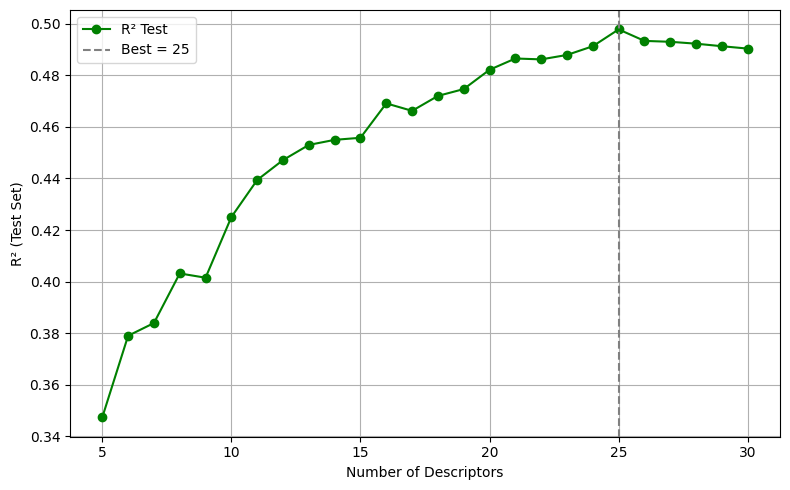

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os

# ========== SECTION 5a: Optimal Descriptor Count Selection (Best R² Only) ==========

# Train initial model to get feature importance
rf_initial = RandomForestRegressor(n_estimators=200, random_state=42)
rf_initial.fit(X_vif, y_all)
feature_importance = pd.Series(rf_initial.feature_importances_, index=X_vif.columns).sort_values(ascending=False)

# Evaluate models using top N descriptors
metrics = []
descriptor_counts = range(5, min(30, len(feature_importance)) + 1, 1)

for n in descriptor_counts:
    top_features = feature_importance.head(n).index.tolist()
    X_selected = X_vif[top_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_all, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred_test = model.predict(X_test_scaled)

    metrics.append({
        "n_descriptors": n,
        "R2_test": r2_score(y_test, y_pred_test),
        "RMSE_test": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "MAE_test": mean_absolute_error(y_test, y_pred_test)
    })

# Convert results to DataFrame
df_metrics = pd.DataFrame(metrics)

# ✅ Identify best R² (Test)
best_row = df_metrics.sort_values(by="R2_test", ascending=False).iloc[0]
best_n = int(best_row["n_descriptors"])
best_r2 = best_row["R2_test"]
print(f"\n✅ Best descriptor count: {best_n} | R² = {best_r2:.4f}, RMSE = {best_row['RMSE_test']:.4f}, MAE = {best_row['MAE_test']:.4f}")

# Final top descriptors
top_features_final = feature_importance.head(best_n).index.tolist()
X_final = X_vif[top_features_final]

# ✅ Plot R² Test only (without metrics annotation)
plt.figure(figsize=(8, 5))
plt.plot(df_metrics["n_descriptors"], df_metrics["R2_test"], label="R² Test", marker='o', color='green')
plt.axvline(best_n, color='gray', linestyle='--', label=f"Best = {best_n}")

plt.xlabel("Number of Descriptors")
plt.ylabel("R² (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# 📁 Save plot
plot_dir = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\2\\Plots"
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, "Best_R2_vs_Descriptor_Count.tiff"), dpi=300)
plt.show()


✅ Original R²: 0.4978


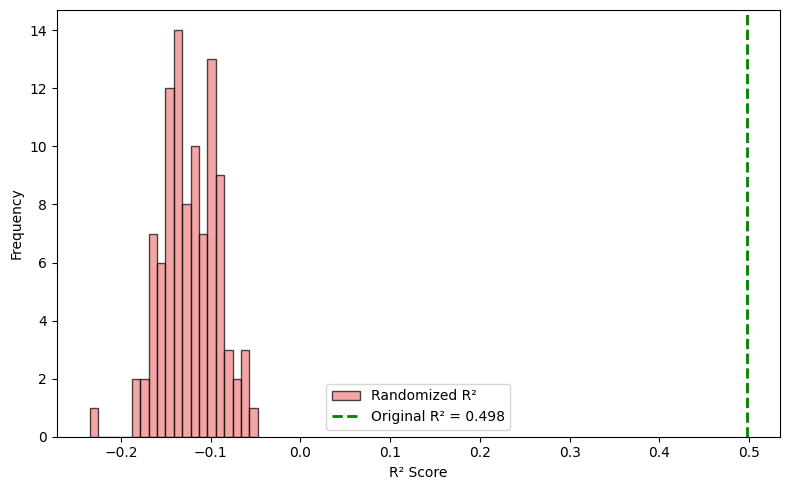


🎯 Y-randomization summary:
Number of randomized models with R² ≥ original: 0 / 100


In [50]:
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os

# ✅ Use optimal descriptor set selected previously
X_selected = X_vif[top_features_final]  # Ensure top_features_final is defined from earlier code
y_true = y_all.copy()

# ✅ Original model performance
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_true, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

original_model = RandomForestRegressor(n_estimators=200, random_state=42)
original_model.fit(X_train_scaled, y_train)
y_pred = original_model.predict(X_test_scaled)

original_r2 = r2_score(y_test, y_pred)
print(f"✅ Original R²: {original_r2:.4f}")

# ✅ Y-Randomization
n_iterations = 100
r2_randomized = []

for i in range(n_iterations):
    y_shuffled = shuffle(y_true, random_state=i)
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_selected, y_shuffled, test_size=0.3, random_state=42)

    scaler_r = StandardScaler()
    X_train_r_scaled = scaler_r.fit_transform(X_train_r)
    X_test_r_scaled = scaler_r.transform(X_test_r)

    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_r_scaled, y_train_r)
    y_pred_r = model.predict(X_test_r_scaled)
    r2_r = r2_score(y_test_r, y_pred_r)
    r2_randomized.append(r2_r)

# ✅ Plot distribution of randomized R²
plt.figure(figsize=(8, 5))
plt.hist(r2_randomized, bins=20, color='lightcoral', edgecolor='black', alpha=0.7, label="Randomized R²")
plt.axvline(original_r2, color='green', linestyle='--', linewidth=2, label=f"Original R² = {original_r2:.3f}")
plt.xlabel("R² Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

# 📁 Save plot
plot_dir = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\2\\Plots"
os.makedirs(plot_dir, exist_ok=True)
plot_path_tiff = os.path.join(plot_dir, "Y_randomization.tiff")
plt.savefig(plot_path_tiff, dpi=300, format='tiff')
plt.show()

# ✅ Interpretation
count_better = sum(r >= original_r2 for r in r2_randomized)
print(f"\n🎯 Y-randomization summary:")
print(f"Number of randomized models with R² ≥ original: {count_better} / {n_iterations}")


In [52]:
from sklearn.utils import shuffle

# ✅ Final train/test split using selected descriptors
X_train, X_test, y_train, y_test = train_test_split(X_final, y_all, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Train final model on real data
final_model = RandomForestRegressor(n_estimators=200, random_state=42)
final_model.fit(X_train_scaled, y_train)
y_pred_final = final_model.predict(X_test_scaled)
r2_original = r2_score(y_test, y_pred_final)

# ✅ Y-randomization loop
r2_randomized = []
n_permutations = 100

for i in range(n_permutations):
    y_random = shuffle(y_all, random_state=i)
    y_train_r, y_test_r = train_test_split(y_random, test_size=0.3, random_state=42)
    
    model_r = RandomForestRegressor(n_estimators=200, random_state=42)
    model_r.fit(X_train_scaled, y_train_r)  # keep X the same
    y_pred_r = model_r.predict(X_test_scaled)
    
    r2_randomized.append(r2_score(y_test_r, y_pred_r))

# ✅ Compute cR²p
mean_r2_random = np.mean(r2_randomized)
c_r2p = r2_original * (1 - mean_r2_random)

print("\n🎯 Y-Randomization Summary:")
print(f"Original R² on Test Set: {r2_original:.4f}")
print(f"Mean R² from Randomized Models: {mean_r2_random:.4f}")
print(f"Y-Randomization Coefficient (cR²p): {c_r2p:.4f}")

# ✅ Interpretation
if c_r2p > 0.5:
    print("✅ Model is statistically robust (cR²p > 0.5).")
else:
    print("⚠️ Model may not be robust (cR²p ≤ 0.5). Consider descriptor refinement or more data.")



🎯 Y-Randomization Summary:
Original R² on Test Set: 0.4978
Mean R² from Randomized Models: -0.1234
Y-Randomization Coefficient (cR²p): 0.5592
✅ Model is statistically robust (cR²p > 0.5).


In [12]:
# ========== SECTION 6: VIF of Final Selected Descriptors ==========
vif_final_df = calculate_vif(X_final)
print("\n📌 VIF for Final Selected Descriptors:")
print(vif_final_df.sort_values(by="VIF", ascending=True))


📌 VIF for Final Selected Descriptors:
                    Feature       VIF
21               fr_hdrzone  1.041132
19            fr_morpholine  1.090008
23                    fr_SH  1.273755
12               PEOE_VSA11  1.462533
22              fr_pyridine  1.463316
13                PEOE_VSA5  1.470420
10              VSA_EState9  1.611380
4               VSA_EState5  1.622206
15           fr_aryl_methyl  1.639383
20                 fr_Ar_NH  1.709685
1              BCUT2D_MRLOW  1.753164
11              fr_bicyclic  1.846699
18    fr_para_hydroxylation  1.894790
0             NumSpiroAtoms  2.070384
24  NumAliphaticCarbocycles  2.137906
8               EState_VSA5  2.265529
14         fr_unbrch_alkane  2.460970
3                PEOE_VSA10  2.526173
16                   fr_N_O  2.672574
2         MinAbsEStateIndex  2.712639
5               VSA_EState8  2.880063
6               EState_VSA6  2.916459
7               EState_VSA7  2.917365
9                PEOE_VSA12  3.181376
17         

In [16]:
# ========== SECTION 7a: Mean Effect Calculation ==========

import numpy as np
import pandas as pd

# ---- Step 1: Basic statistics and importances ----
means  = X_final.mean()
stdevs = X_final.std()
betas  = rf_initial.feature_importances_[:len(X_final.columns)]

# ---- Step 2: Raw mean effect calculation ----
raw_effects = (betas * means) / stdevs
raw_effects = raw_effects.replace([np.inf, -np.inf], 0).fillna(0)

# ---- Step 3: Normalize so that contributions sum to 1 ----
den = raw_effects.sum()
if np.isclose(den, 0.0):
    raise ValueError("Mean Effect undefined: net contribution ≈ 0.")
mean_effect = raw_effects / den

# ---- Step 4: Positive/Negative split ----
me_pos = mean_effect.clip(lower=0)
me_neg = mean_effect.clip(upper=0)

# ---- Step 5: Assemble clean DataFrame ----
mean_effect_df = pd.DataFrame({
    'Descriptor': X_final.columns,
    'Mean': means.values,
    'Std': stdevs.values,
    'Importance': betas,
    'Raw Effect': raw_effects.values,
    'Mean Effect': mean_effect.values,
    '% Contribution': mean_effect.values * 100,
    'Positive Part': me_pos.values,
    'Negative Part': me_neg.values
}).sort_values(by='Mean Effect', ascending=False).reset_index(drop=True)

# ---- Step 6: Round for clarity ----
mean_effect_df = mean_effect_df.round({
    'Mean': 3, 'Std': 3, 'Importance': 4,
    'Raw Effect': 4, 'Mean Effect': 4,
    '% Contribution': 2, 'Positive Part': 4, 'Negative Part': 4
})

# ---- Step 7: Print sections ----
print("\n📊 Mean Effect Summary (sum=1)\n")

print("=== Descriptor Stats ===")
print(mean_effect_df[['Descriptor','Mean','Std','Importance']].to_string(index=False))

print("\n=== Contribution Effects ===")
print(mean_effect_df[['Descriptor','Raw Effect','Mean Effect','% Contribution']].to_string(index=False))

print("\n=== Split Contributions ===")
print(mean_effect_df[['Descriptor','Positive Part','Negative Part']].to_string(index=False))

print("\nCheck Totals:")
print("Sum of mean effects =", mean_effect.sum())
print("Sum of positives =", me_pos.sum(), "| Sum of negatives =", me_neg.sum())



📊 Mean Effect Summary (sum=1)

=== Descriptor Stats ===
             Descriptor   Mean    Std  Importance
      MinAbsEStateIndex  0.140  0.116      0.0724
       fr_unbrch_alkane  0.955  1.267      0.0572
            fr_bicyclic  0.729  1.168      0.0469
              PEOE_VSA5  2.097  5.178      0.0652
          NumSpiroAtoms  0.085  0.279      0.0799
             PEOE_VSA11  2.564  4.981      0.0459
          fr_morpholine  0.020  0.144      0.1327
            EState_VSA7 28.377 20.576      0.0131
             PEOE_VSA10  7.705  9.434      0.0220
            VSA_EState9  0.590  1.522      0.0453
            VSA_EState8  2.349  2.649      0.0186
         fr_aryl_methyl  0.294  0.630      0.0306
                 fr_N_O  0.533  0.528      0.0064
NumAliphaticCarbocycles  0.198  0.510      0.0096
  fr_para_hydroxylation  0.495  0.793      0.0047
               fr_Ar_NH  0.233  0.446      0.0055
            EState_VSA5 11.776 12.628      0.0030
            fr_pyridine  0.193  0.423      

In [ ]:
#CREATE CSV

In [18]:
import pandas as pd
import numpy as np
import os

# === Step 1: Get descriptor-level statistics ===
means = X_final.mean()
stdevs = X_final.std()
descriptors = X_final.columns
betas = rf_initial.feature_importances_[:len(descriptors)]

# ---- Raw effect ----
raw_effects = (betas * means) / stdevs
raw_effects = raw_effects.replace([np.inf, -np.inf], 0).fillna(0)

# ---- Normalize to get Mean Effect (sum = 1) ----
den = raw_effects.sum()
if np.isclose(den, 0.0):
    raise ValueError("Mean Effect undefined: denominator is ~0.")
mean_effects = raw_effects / den

# === Step 2: Create descriptor summary DataFrame ===
descriptor_summary = pd.DataFrame({
    'Descriptor': descriptors,
    'Mean': means.values,
    'Std': stdevs.values,
    'Importance': betas,
    'Mean Effect': mean_effects.values
})

# === Step 3: Get VIF values and align by Descriptor ===
vif_df = calculate_vif(X_final)

# Ensure the correct merge column
if 'Feature' in vif_df.columns:
    vif_df.rename(columns={'Feature': 'Descriptor'}, inplace=True)

# Merge on 'Descriptor' (ensures 1 row per descriptor)
descriptor_summary = descriptor_summary.merge(vif_df, on='Descriptor', how='inner')

# === Step 4: Save to CSV ===
csv_path = r"C:\Users\Haisoj\Desktop\PhD Folder\Thesis\DLBCL\ML\2\Plot 1.csv"
descriptor_summary.to_csv(csv_path, index=False)

print(f"✅ CSV created successfully with shape {descriptor_summary.shape}")
print(f"📁 File saved at:\n{csv_path}")
print(f"Σ Mean Effect = {descriptor_summary['Mean Effect'].sum():.4f}")


✅ CSV created successfully with shape (25, 6)
📁 File saved at:
C:\Users\Haisoj\Desktop\PhD Folder\Thesis\DLBCL\ML\2\Plot 1.csv
Σ Mean Effect = 1.0000


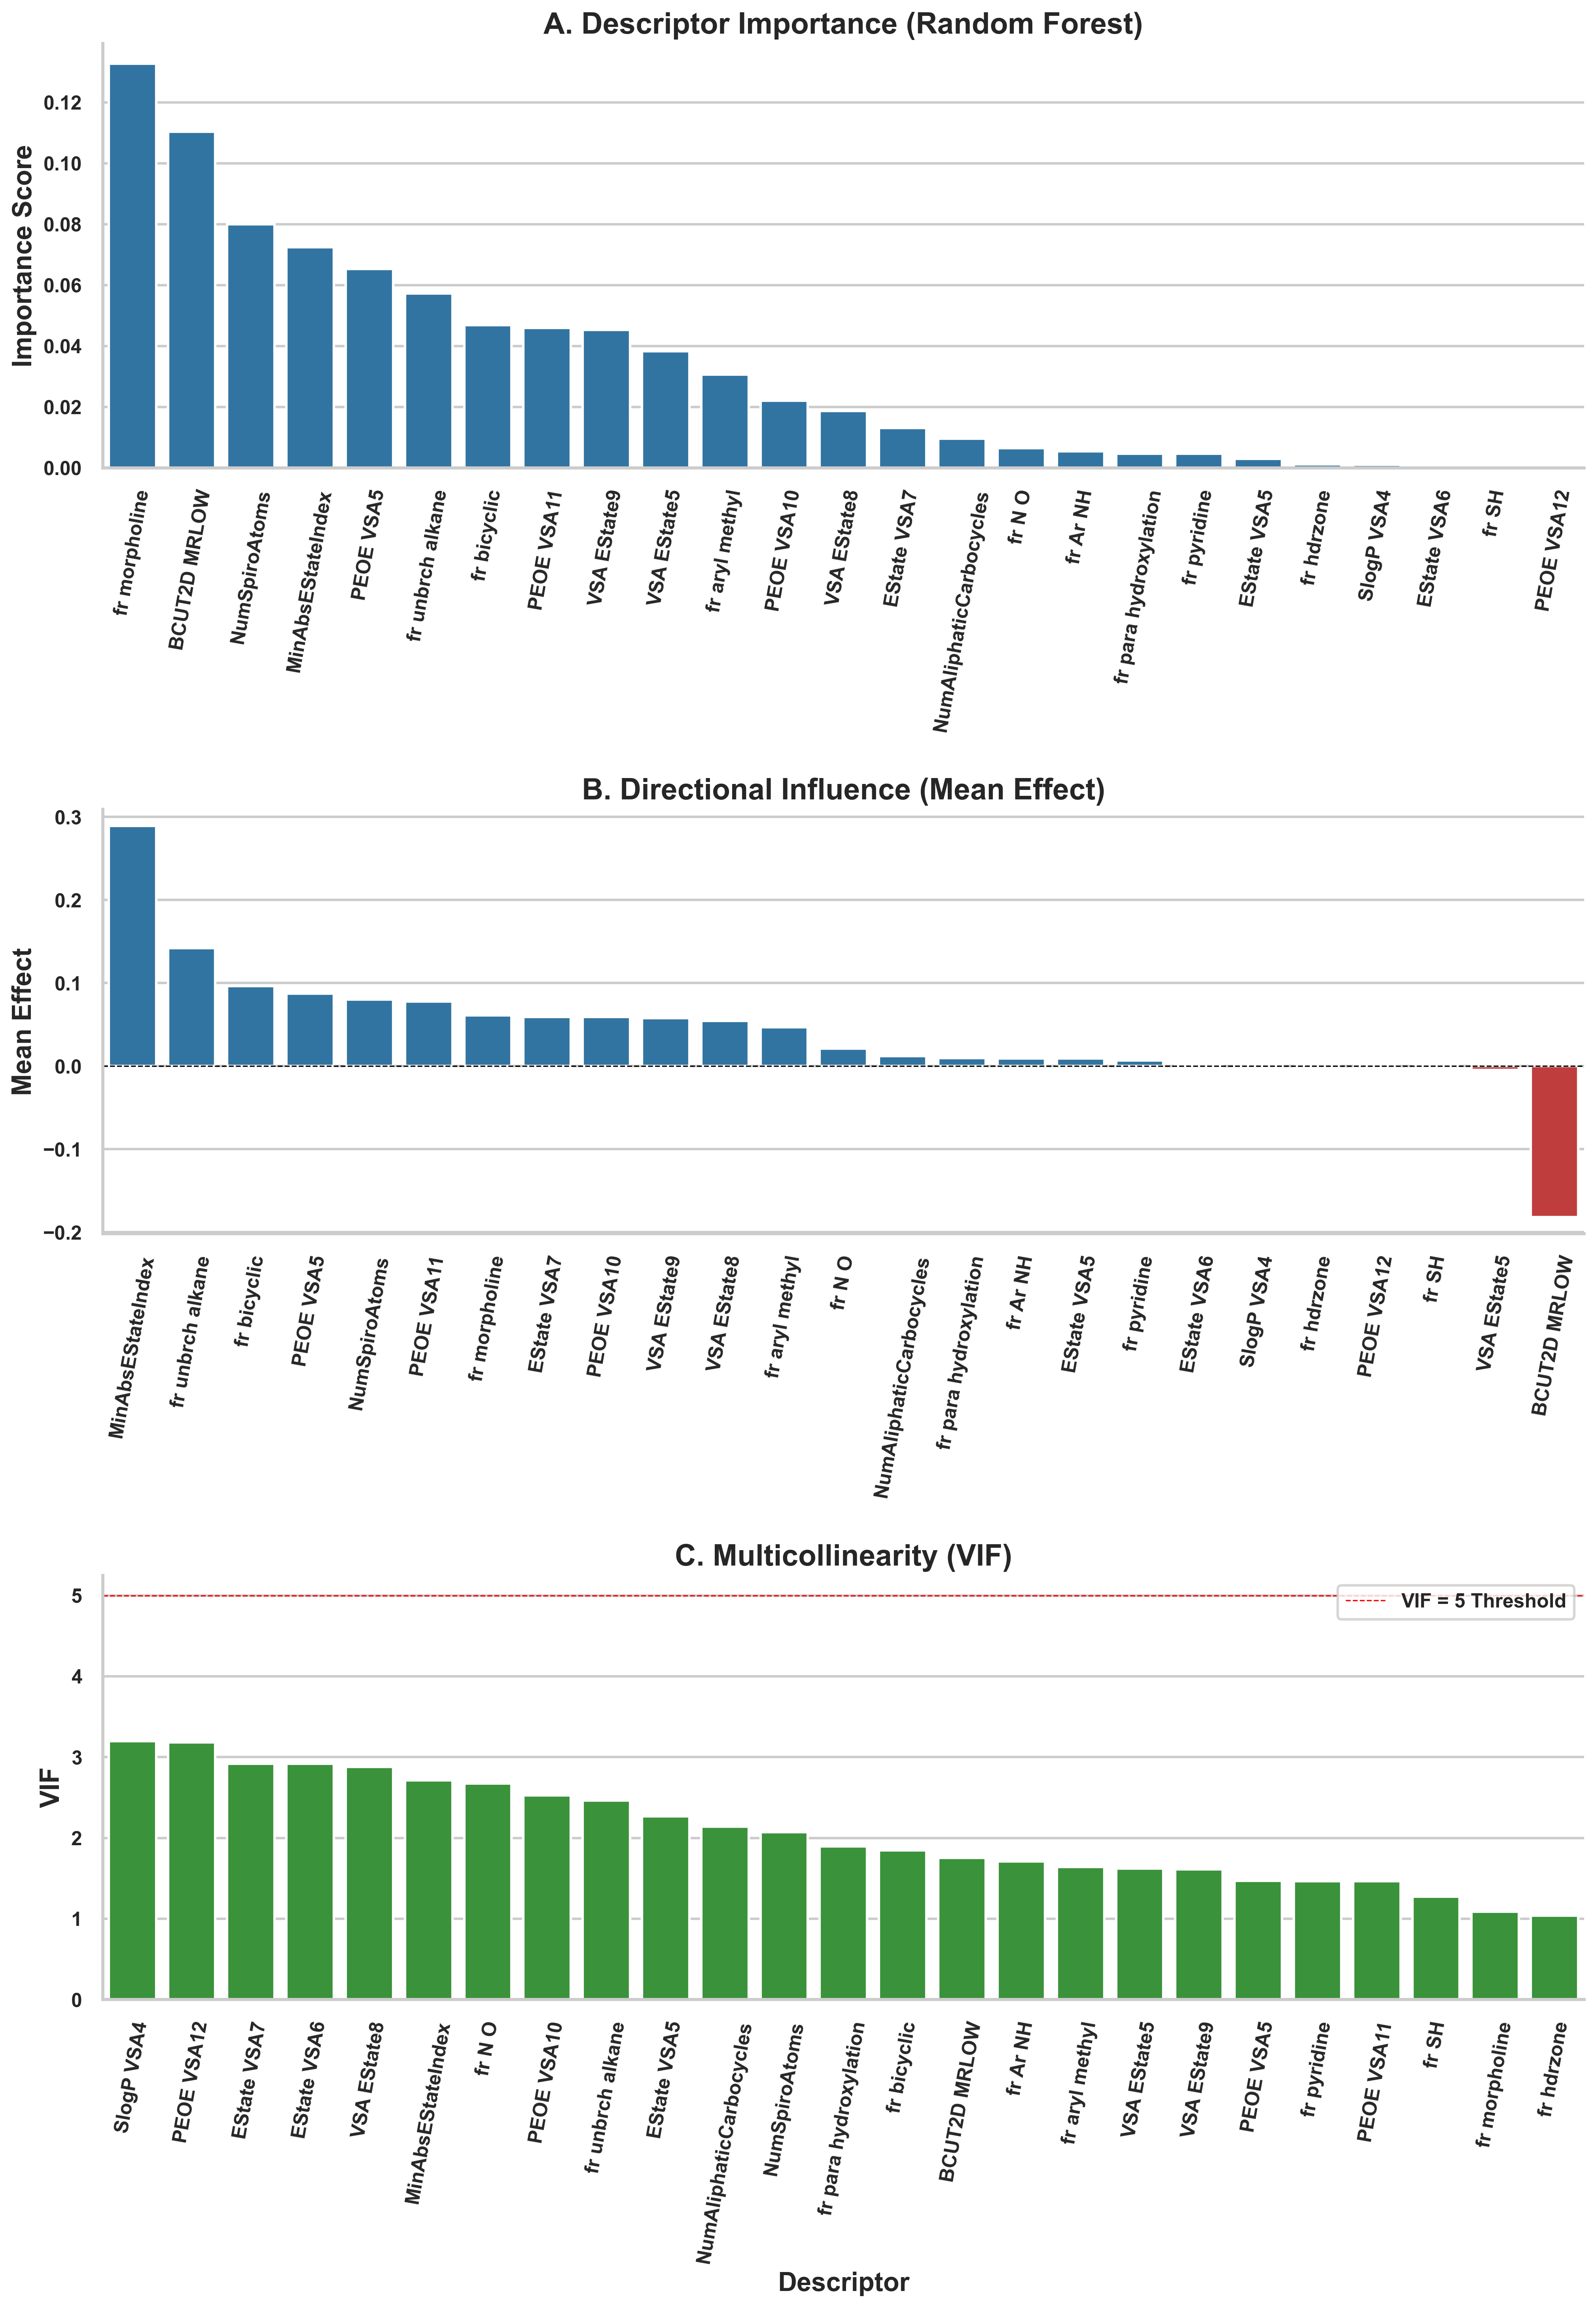

✅ Enhanced high-resolution plot saved to:
C:\Users\Haisoj\Desktop\PhD Folder\Thesis\DLBCL\ML\2\Descriptor_Analysis_Plots.tiff


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataset
file_path = r"C:\Users\Haisoj\Desktop\PhD Folder\Thesis\DLBCL\ML\2\Plot 1.csv"
df = pd.read_csv(file_path)

# Optional: Shorten descriptor names for clarity in tight plots
df['Descriptor'] = df['Descriptor'].str.replace('descriptor_', 'D_', regex=False)
df['Descriptor'] = df['Descriptor'].str.replace('_', ' ', regex=False)

# Define output path
output_path = os.path.join(os.path.dirname(file_path), "Descriptor_Analysis_Plots.tiff")

# Set high-contrast Seaborn style
sns.set(style="whitegrid", context="talk")  # Bigger context for readability
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'font.weight': 'bold',
    'axes.labelweight': 'bold'
})

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 20), dpi=300)

# === Plot A: Feature Importance ===
df_imp = df.sort_values(by='Importance', ascending=False)
sns.barplot(
    x='Descriptor',
    y='Importance',
    data=df_imp,
    ax=axes[0],
    color='#1f77b4'
)
axes[0].set_title('A. Descriptor Importance (Random Forest)', weight='bold')
axes[0].set_ylabel('Importance Score')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=80)

# === Plot B: Mean Effect ===
df_me = df.sort_values(by='Mean Effect', ascending=False)
bar_colors = ['#1f77b4' if v > 0 else '#d62728' for v in df_me['Mean Effect']]

sns.barplot(
    x='Descriptor',
    y='Mean Effect',
    data=df_me,
    palette=bar_colors,
    ax=axes[1]
)
axes[1].set_title('B. Directional Influence (Mean Effect)', weight='bold')
axes[1].set_ylabel('Mean Effect')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=80)
axes[1].axhline(0, color='black', linestyle='--', linewidth=0.8)

ymin, ymax = df_me['Mean Effect'].min(), df_me['Mean Effect'].max()
axes[1].set_ylim(ymin - 0.02, ymax + 0.02)

# === Plot C: VIF ===
df_vif = df.sort_values(by='VIF', ascending=False)
sns.barplot(
    x='Descriptor',
    y='VIF',
    data=df_vif,
    ax=axes[2],
    color='#2ca02c'
)
axes[2].set_title('C. Multicollinearity (VIF)', weight='bold')
axes[2].set_ylabel('VIF')
axes[2].set_xlabel('Descriptor')
axes[2].tick_params(axis='x', rotation=80)
axes[2].axhline(5, color='red', linestyle='--', linewidth=0.8, label='VIF = 5 Threshold')
axes[2].legend(loc='upper right')

# Final cleanup
for ax in axes:
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

# Reduce padding, improve layout
plt.tight_layout(pad=1.5)

# Save at very high resolution (ideal for print)
fig.savefig(output_path, format='tiff', dpi=600, bbox_inches='tight')  # increased to 600 dpi
plt.show()

print(f"✅ Enhanced high-resolution plot saved to:\n{output_path}")


In [16]:
# ========== SECTION 8: Train-Test Split & Model Evaluation (Before Tuning) ==========
X_train, X_test, y_train, y_test = train_test_split(X_final, y_all, test_size=0.3, random_state=42)
print(f"\n✅ Training set size: {X_train.shape}, Test set size: {X_test.shape}")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Support Vector Regression": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "KNN Regressor": KNeighborsRegressor()
}

results_train_test = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    results_train_test.append({
        "Model": name,
        "R² (Train)": r2_score(y_train, y_train_pred),
        "MSE (Train)": mean_squared_error(y_train, y_train_pred),
        "MAE (Train)": mean_absolute_error(y_train, y_train_pred),
        "R² (Test)": r2_score(y_test, y_test_pred),
        "MSE (Test)": mean_squared_error(y_test, y_test_pred),
        "MAE (Test)": mean_absolute_error(y_test, y_test_pred)
    })

results_train_test_df = pd.DataFrame(results_train_test).sort_values(by="R² (Test)", ascending=False)
print("\n📊 Model Performance on Train and Test Set (Before Tuning):")
print(results_train_test_df.to_string(index=False))


✅ Training set size: (1396, 25), Test set size: (599, 25)

📊 Model Performance on Train and Test Set (Before Tuning):
                    Model  R² (Train)  MSE (Train)  MAE (Train)  R² (Test)  MSE (Test)  MAE (Test)
            Random Forest    0.925482     0.093142     0.231724   0.496818    0.596589    0.597979
            KNN Regressor    0.596975     0.503748     0.540980   0.424963    0.681784    0.651606
        Gradient Boosting    0.608294     0.489601     0.552670   0.412706    0.696316    0.664562
Support Vector Regression    0.581470     0.523129     0.504012   0.411942    0.697222    0.642119
         Ridge Regression    0.249221     0.938413     0.767822   0.227415    0.916003    0.761201
        Linear Regression    0.249221     0.938413     0.767812   0.227331    0.916102    0.761225
         Lasso Regression    0.000000     1.249919     0.886818  -0.000339    1.186036    0.882519


In [18]:
# ========== SECTION 9: Cross-Validation ==========
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for name, model in models.items():
    scores = cross_validate(
        model, X_train_scaled, y_train, cv=cv,
        scoring={
            'r2': make_scorer(r2_score),
            'mse': make_scorer(mean_squared_error),
            'mae': make_scorer(mean_absolute_error)
        },
        return_train_score=False
    )
    cv_results.append({
        "Model": name,
        "CV R² (Train)": np.mean(scores['test_r2']),
        "CV MSE (Train)": np.mean(scores['test_mse']),
        "CV MAE (Train)": np.mean(scores['test_mae'])
    })

df_cv = pd.DataFrame(cv_results).sort_values(by="CV R² (Train)", ascending=False)
print("\n📈 5-Fold Cross-Validation Results:")
print(df_cv.to_string(index=False))



📈 5-Fold Cross-Validation Results:
                    Model  CV R² (Train)  CV MSE (Train)  CV MAE (Train)
            Random Forest       0.421280        0.722405        0.646950
        Gradient Boosting       0.367057        0.789391        0.697258
Support Vector Regression       0.364336        0.794138        0.679405
            KNN Regressor       0.314138        0.854305        0.702299
         Ridge Regression       0.215137        0.978504        0.782309
        Linear Regression       0.215093        0.978554        0.782310
         Lasso Regression      -0.000449        1.250049        0.886924


In [20]:
# ========== SECTION 10: Hyperparameter Tuning (Expanded Search Grid) ==========
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd

# Expanded search grids
param_grids = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear', 'poly'],
            'gamma': ['scale', 'auto']
        }
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    "Ridge": {
        "model": Ridge(),
        "params": {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    }
}

# Add Linear Regression (no tuning)
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Run GridSearchCV for all other models
tuned_models = {}
for name, entry in param_grids.items():
    print(f"\n🔍 Tuning {name}...")
    grid = GridSearchCV(
        entry["model"],
        entry["params"],
        cv=5,
        scoring="r2",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_scaled, y_train)
    tuned_models[name] = grid



🔍 Tuning Random Forest...
Fitting 5 folds for each of 180 candidates, totalling 900 fits

🔍 Tuning Gradient Boosting...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

🔍 Tuning SVR...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

🔍 Tuning KNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🔍 Tuning Ridge...
Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [22]:
# ========== SECTION 11: Model Evaluation After Tuning ==========
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    if hasattr(model, "best_estimator_"):
        estimator = model.best_estimator_
        best_params = model.best_params_
    else:
        estimator = model
        best_params = "N/A"
    
    y_train_pred = estimator.predict(X_train)
    y_test_pred = estimator.predict(X_test)
    
    return {
        "Model": name,
        "R² (Train)": r2_score(y_train, y_train_pred),
        "R² (Test)": r2_score(y_test, y_test_pred),
        "MSE (Test)": mean_squared_error(y_test, y_test_pred),
        "MAE (Test)": mean_absolute_error(y_test, y_test_pred),
        "Best Params": best_params
    }

# Evaluate all models
results = []
for name, grid in tuned_models.items():
    results.append(evaluate_model(name, grid, X_train_scaled, X_test_scaled, y_train, y_test))

# Add linear model evaluation (no tuning)
results.append(evaluate_model("Linear Regression", linear_model, X_train_scaled, X_test_scaled, y_train, y_test))

# Convert to DataFrame
eval_df = pd.DataFrame(results)
eval_df_sorted = eval_df.sort_values(by="R² (Test)", ascending=False).reset_index(drop=True)

# Display Results
print("\n📈 Model Comparison Summary (After Hyperparameter Tuning):")
print(eval_df_sorted[["Model", "R² (Train)", "R² (Test)", "MSE (Test)", "MAE (Test)", "Best Params"]].to_string(index=False))

# Extract best model name and estimator
best_model_row = eval_df_sorted.iloc[0]
best_model_name = best_model_row["Model"]
print(f"\n✅ Selected Best Model: {best_model_name}")


📈 Model Comparison Summary (After Hyperparameter Tuning):
            Model  R² (Train)  R² (Test)  MSE (Test)  MAE (Test)                                                                             Best Params
    Random Forest    0.926472   0.500850    0.591809    0.596861 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Gradient Boosting    0.937827   0.499397    0.593532    0.604791                             {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
              KNN    0.997188   0.491457    0.602946    0.599421                                       {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
              SVR    0.581470   0.411942    0.697222    0.642119                                             {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
            Ridge    0.247697   0.232619    0.909833    0.759827                                                                          {'alpha': 100}
Linear Regression    0.

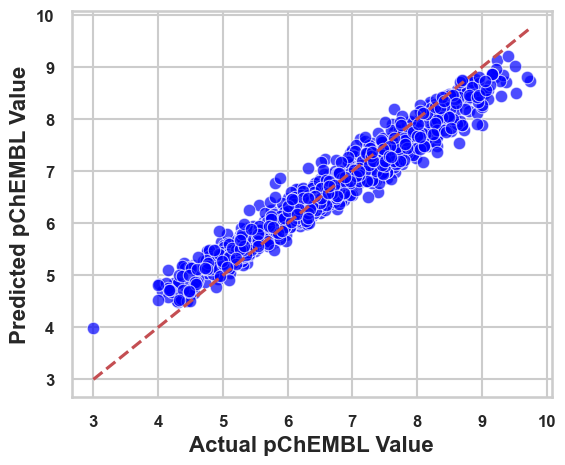

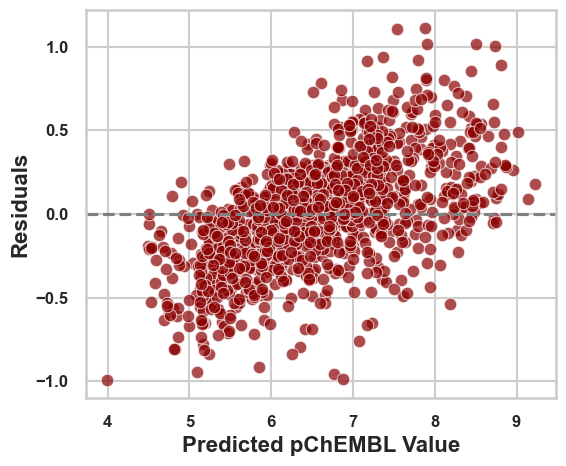

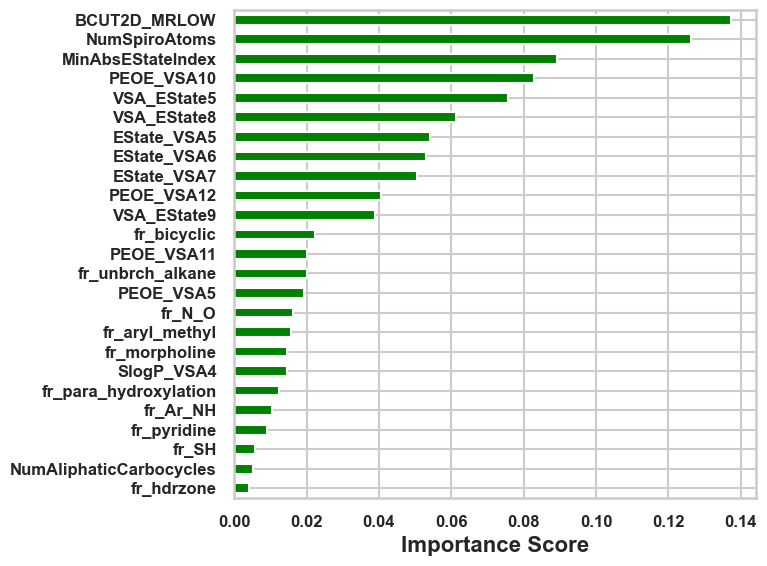

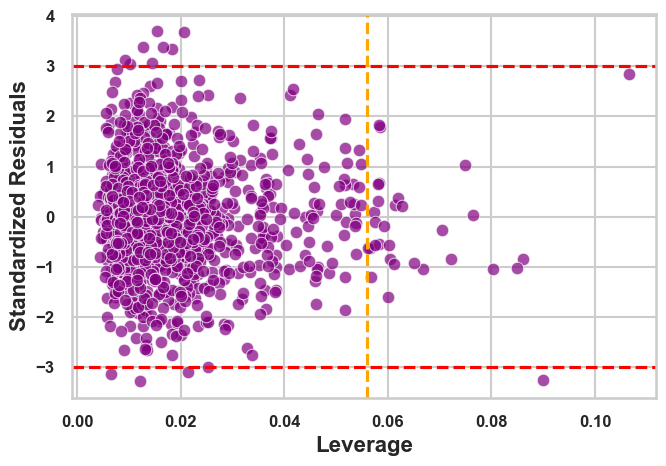

✅ All plots generated and saved as TIFF in:
C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\2\\Plots


In [63]:
# ========== SECTION 13: Plots for Best Model ==========
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# 📁 Set save directory
save_dir = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\2\\Plots"
os.makedirs(save_dir, exist_ok=True)

# ✅ Incorporate best tuned Random Forest parameters
model_rf_final = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)
model_rf_final.fit(X_train_scaled, y_train)

# 📈 Predictions and residuals
y_pred_rf = model_rf_final.predict(X_train_scaled)
residuals = y_train - y_pred_rf
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# 🎯 Leverage calculation for Williams plot
X_rf_const = sm.add_constant(X_train_scaled)
hat_matrix = X_rf_const @ np.linalg.inv(X_rf_const.T @ X_rf_const) @ X_rf_const.T
leverage = np.diag(hat_matrix)
n, p = X_train_scaled.shape
leverage_threshold = 3 * (p + 1) / n

# 🔍 Feature importance
importances = model_rf_final.feature_importances_
top_features_plot = pd.Series(importances, index=top_features_final).sort_values(ascending=False)

# 🔵 Actual vs Predicted plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_train, y=y_pred_rf, color='blue', alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual pChEMBL Value")
plt.ylabel("Predicted pChEMBL Value")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Actual_vs_Predicted.tiff"), dpi=300)
plt.show()

# 🔴 Residual plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_pred_rf, y=residuals, color='darkred', alpha=0.7)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted pChEMBL Value")
plt.ylabel("Residuals")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Residuals.tiff"), dpi=300)
plt.show()

# 🟢 Feature importance bar plot
plt.figure(figsize=(8, 6))
top_features_plot.sort_values().plot(kind='barh', color='green')
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Feature_Importance.tiff"), dpi=300)
plt.show()

# 🟣 Williams plot (Standardized Residuals vs Leverage)
max_lev = np.percentile(leverage, 99.5)
mask = leverage < max_lev

plt.figure(figsize=(7, 5))
sns.scatterplot(x=leverage[mask], y=standardized_residuals[mask], color='purple', alpha=0.7)
plt.axhline(3, linestyle='--', color='red')
plt.axhline(-3, linestyle='--', color='red')
plt.axvline(leverage_threshold, linestyle='--', color='orange')
plt.xlabel("Leverage")
plt.ylabel("Standardized Residuals")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Williams_Plot_Filtered.tiff"), dpi=300)
plt.show()

print("✅ All plots generated and saved as TIFF in:")
print(save_dir)


In [24]:
# ========== SECTION 14: Save Best Model Predictions and Top Compounds ==========

import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# ✅ Step 1: Reset index for alignment
X_top20 = X_final.reset_index(drop=True)
y_final = y_all.reset_index(drop=True)
df_full_reset = df_full.reset_index(drop=True)

# ✅ Step 2: Extract IDs and SMILES
ids = df_full_reset.loc[X_top20.index, 'Molecule ChEMBL ID']
smiles = df_full_reset.loc[X_top20.index, 'Smiles']

# ✅ Step 3: Scale the features
scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X_top20)

# ✅ Step 4: Train Best Model — Tuned Random Forest
model_best = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)
model_best.fit(X_scaled_final, y_final)

# ✅ Step 5: Predict and calculate residuals
y_pred_best = model_best.predict(X_scaled_final)
residuals_best = y_final - y_pred_best

# ✅ Step 6: Leverage calculation
X_const_final = sm.add_constant(X_scaled_final)
hat_matrix_best = X_const_final @ np.linalg.inv(X_const_final.T @ X_const_final) @ X_const_final.T
leverage_best = np.diag(hat_matrix_best)

# ✅ Step 7: Combine all results into a DataFrame
results_df = pd.DataFrame({
    'Molecule ChEMBL ID': ids.values,
    'Smiles': smiles.values,
    'Actual pChEMBL': y_final.values,
    'Predicted pChEMBL': y_pred_best,
    'Residuals': residuals_best,
    'Leverage': leverage_best
})

# Add descriptor values
for feature in X_top20.columns:
    results_df[feature] = X_top20[feature].values

# ✅ Step 8: Apply applicability domain filter
h_star = 3 * (X_top20.shape[1] + 1) / X_top20.shape[0]
within_domain_df = results_df[results_df['Leverage'] <= h_star].copy()

# ✅ Step 9: Extract top 20 predicted compounds
top20_compounds = within_domain_df.sort_values(by='Predicted pChEMBL', ascending=False).head(20).reset_index(drop=True)

# ✅ Output preview
print("\n📊 Full Dataset with Predictions and Descriptors:")
print(results_df.head())

print("\n💎 Top 20 Predicted Compounds Within Applicability Domain:")
print(top20_compounds[['Molecule ChEMBL ID', 'Smiles', 'Predicted pChEMBL']])

# ✅ Step 10: Save results
save_path = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\2"
os.makedirs(save_path, exist_ok=True)

results_df.to_csv(os.path.join(save_path, "Full_Prediction_Results_BestModel.csv"), index=False)
top20_compounds.to_csv(os.path.join(save_path, "Top20_BestModel_Predicted_Compounds.csv"), index=False)

print("\n✅ Saved to:")
print("- Full_Prediction_Results_BestModel.csv")
print("- Top20_BestModel_Predicted_Compounds.csv")



📊 Full Dataset with Predictions and Descriptors:
  Molecule ChEMBL ID                                             Smiles  \
0      CHEMBL4080164     Cc1[nH]c2ccccc2c1CCNCc1cccc(/C=C/C(=O)NO)c1.Cl   
1      CHEMBL5274004      CN(CCc1ccccc1)S(=O)(=O)c1cccc(/C=C/C(=O)NO)c1   
2      CHEMBL4861467  CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(CC1CC1)C...   
3      CHEMBL2105763     Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21   
4      CHEMBL4878197  CCC(=O)CCCCC[C@@H]1NC(=O)[C@H]2CC23CCN(CCCCCCC...   

   Actual pChEMBL  Predicted pChEMBL  Residuals  Leverage  NumSpiroAtoms  \
0            9.74           8.655674   1.084326  0.012063            0.0   
1            9.70           8.719520   0.980480  0.005564            0.0   
2            9.52           9.280260   0.239740  0.011661            1.0   
3            9.52           8.632340   0.887660  0.009087            0.0   
4            9.51           9.002780   0.507220  0.012034            1.0   

   BCUT2D_MRLOW  MinAbsEStateIndex  PEOE_V

⚠️ Leverage threshold (h*): 0.0559
🧪 Total compounds within applicability domain: 1979
🔥 Top 25% high-activity compounds within domain: 197
💊 Drug-like compounds after activity + domain filter: 59
🧬 Selected 10 diverse cluster representatives for docking.


[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerator
[21:22:06] DEPRECATION WARNING: please use MorganGenerat

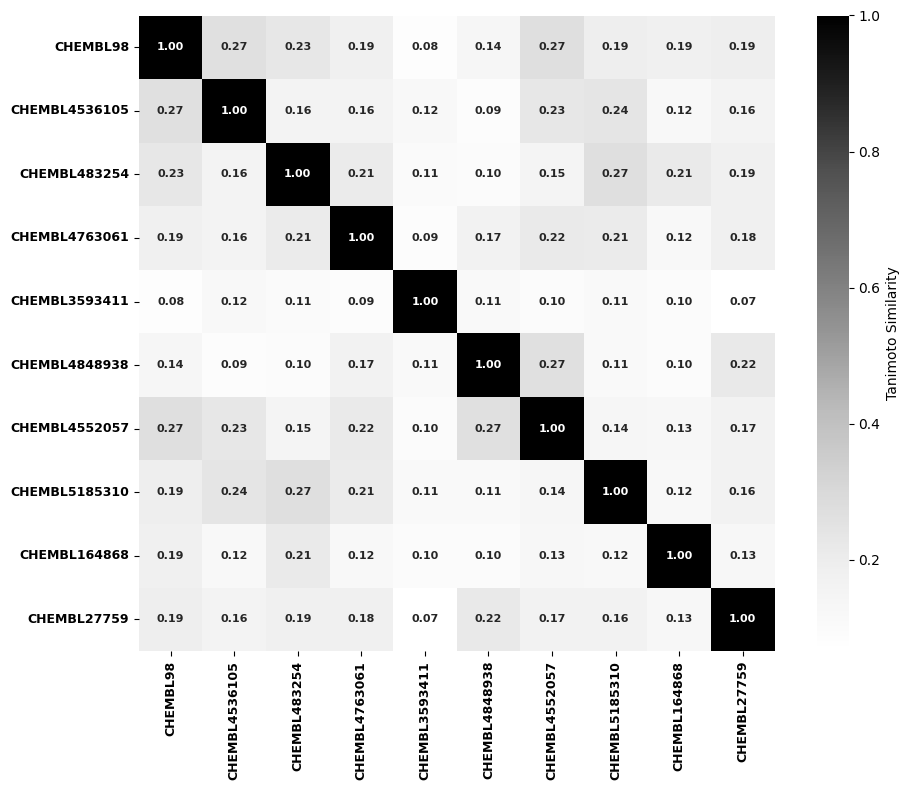


✅ Docking list and heatmap saved to:
C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\2


In [66]:
# ========== SECTION 15: Activity + Drug-Likeness + Clustering Pipeline (Automated RDKit Descriptors Only) ==========

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Crippen
from rdkit.ML.Cluster import Butina
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# ✅ Step 1: Combine prediction, residual, leverage into master DataFrame
df_preds = df_full.copy()
df_preds['Predicted pChEMBL'] = y_pred_best
df_preds['Residuals'] = residuals_best
df_preds['Leverage'] = leverage_best

# ✅ Step 2: Compute leverage threshold
h_star = 3 * (X_train_scaled.shape[1] + 1) / X_train_scaled.shape[0]
print(f"⚠️ Leverage threshold (h*): {h_star:.4f}")

# ✅ Step 3: Filter by applicability domain
df_in_domain = df_preds[df_preds['Leverage'] <= h_star].copy()
print(f"🧪 Total compounds within applicability domain: {df_in_domain.shape[0]}")

# ✅ Step 4: Apply high-activity filter (top 10% within domain)
top_n = int(0.10 * df_in_domain.shape[0])
df_top_active = df_in_domain.sort_values("Predicted pChEMBL", ascending=False).head(top_n)
print(f"🔥 Top 25% high-activity compounds within domain: {df_top_active.shape[0]}")

# ✅ Step 5: Drug-likeness filtering (Lipinski + Veber)
def is_drug_like(mol):
    if mol is None:
        return False
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    rotb = Descriptors.NumRotatableBonds(mol)
    return (mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10 and tpsa <= 140 and rotb <= 10)

df_top_active['Mol'] = df_top_active['Smiles'].apply(Chem.MolFromSmiles)
df_druglike = df_top_active[df_top_active['Mol'].apply(is_drug_like)].copy()
print(f"💊 Drug-like compounds after activity + domain filter: {df_druglike.shape[0]}")

# ✅ Step 6: Compute only model-specific descriptors using RDKit
rdkit_funcs = {name: func for name, func in Descriptors.__dict__.items() if callable(func)}
descriptor_funcs = {name: rdkit_funcs[name] for name in top_features_final if name in rdkit_funcs}

for name, func in descriptor_funcs.items():
    df_druglike[name] = df_druglike['Mol'].apply(func)

# ✅ Step 6.5: Select relevant columns for final docking DataFrame
df_druglike_final = df_druglike[
    ['Smiles', 'Molecule ChEMBL ID', 'pChEMBL Value', 'Predicted pChEMBL', 'Residuals', 'Leverage', 'Mol'] +
    list(descriptor_funcs.keys())
]

# ✅ Step 7: Compute ECFP4 fingerprints
mols = df_druglike_final['Mol'].tolist()
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in mols]

# ✅ Step 8: Compute Tanimoto distance matrix
dists = []
n_fps = len(fps)
for i in range(1, n_fps):
    sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
    dists.extend([1 - x for x in sims])

# ✅ Step 9: Cluster using Butina algorithm (cutoff = 0.7)
clusters = Butina.ClusterData(dists, n_fps, 0.7, isDistData=True)
rep_indices = [cluster[0] for cluster in clusters]

# ✅ Step 10: Extract representative compounds
df_docking = df_druglike_final.iloc[rep_indices].copy()
print(f"🧬 Selected {len(df_docking)} diverse cluster representatives for docking.")

# ✅ Step 11: Generate Tanimoto similarity matrix
rep_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in df_docking['Mol']]
sim_matrix = np.zeros((len(rep_fps), len(rep_fps)))
for i in range(len(rep_fps)):
    for j in range(len(rep_fps)):
        sim_matrix[i, j] = DataStructs.TanimotoSimilarity(rep_fps[i], rep_fps[j])

# ✅ Step 12: Plot similarity heatmap with bold text and axis
ids = df_docking['Molecule ChEMBL ID'].tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(
    sim_matrix,
    cmap='Greys',
    xticklabels=ids,
    yticklabels=ids,
    square=True,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8, "weight": "bold"},
    cbar_kws={'label': 'Tanimoto Similarity'}
)
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
plt.yticks(rotation=0, fontsize=9, fontweight='bold')
plt.tight_layout()

# ✅ Step 13: Save heatmap and docking set
save_path = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\2"
os.makedirs(save_path, exist_ok=True)

plt.savefig(os.path.join(save_path, "Tanimoto_Docking_Heatmap.tiff"), dpi=300)
plt.show()

df_docking.drop(columns=["Mol"], inplace=True)
df_docking.to_csv(os.path.join(save_path, "Docking_Compounds_Selected_Descriptors.csv"), index=False)
print(f"\n✅ Docking list and heatmap saved to:\n{save_path}")


In [40]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# === Load new design SMILES ===
df_new = pd.read_csv(r"C:\Users\Haisoj\Desktop\PhD Folder\Thesis\DLBCL\ML\2\Design\Optimization\Final USED Design Smiles.csv")
df_new['Mol'] = df_new['SMILE'].apply(Chem.MolFromSmiles)
df_new = df_new[df_new['Mol'].notnull()].copy()

# === Compute all RDKit descriptors ===
all_desc = [desc[0] for desc in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(all_desc)
desc_values = [calc.CalcDescriptors(mol) for mol in df_new['Mol']]
desc_df = pd.DataFrame(desc_values, columns=all_desc)

# Combine with SMILES
desc_df = pd.concat([df_new.reset_index(drop=True), desc_df], axis=1)

# === Filter to top features used in model ===
desc_df = desc_df.dropna(subset=top_features_final)
X_new = desc_df[top_features_final].copy()

# === Scale using the same scaler from training ===
X_new_scaled = scaler_final.transform(X_new)

# === Predict using trained Random Forest ===
y_pred_new = model_best.predict(X_new_scaled)

# === Calculate Leverage using same training space ===
# X_train_scaled must be from training time
def add_constant_column(X):
    return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

X_train_const = add_constant_column(X_train_scaled)
X_new_const = add_constant_column(X_new_scaled)

XTX_inv = np.linalg.inv(X_train_const.T @ X_train_const)

# Leverage: h = xᵢᵀ (XᵀX)^(-1) xᵢ
leverages_new = np.einsum('ij,jk,ik->i', X_new_const, XTX_inv, X_new_const)

# === Calculate leverage threshold h* ===
h_star = 3 * (X_train_const.shape[1]) / X_train_const.shape[0]

# === Combine results ===
df_results = pd.DataFrame({
    'SMILE': desc_df['SMILE'],
    'Predicted pChEMBL': y_pred_new,
    'Leverage': leverages_new,
    'In Applicability Domain': leverages_new <= h_star
})

# Optional: add descriptors for inspection/debugging
for feature in top_features_final:
    df_results[feature] = X_new[feature].values

# === Save to disk ===
save_path = r"C:\Users\Haisoj\Desktop\PhD Folder\Thesis\DLBCL\ML\2\Design\Optimization"
os.makedirs(save_path, exist_ok=True)

df_results.to_csv(os.path.join(save_path, "New_Design_Prediction_Leverage.csv"), index=False)

print("✅ Done. Saved to New_Design_Prediction_Leverage.csv")
print(df_results.head())


✅ Done. Saved to New_Design_Prediction_Leverage.csv
                                               SMILE  Predicted pChEMBL  \
0  CC1=CC=C(C=N1)S(=O)(=O)C1=CC=C(CNC(=O)C2=CC3=C...           5.937328   
1  CC1=CC=CC(=C1)S(=O)(=O)C1=CC=C(CNC(=O)C2=CC3=C...           6.259860   
2  N=S(=O)(C1=CC=CC=C1)C1=CC=C(CNC(=O)C2=CC3=CC=N...           6.713261   
3  FC(F)(F)C1=CC=CC=C1S(=O)(=O)C1=CC=C(CNC(=O)C2=...           6.163910   
4  CC1=C(N2C=CC=CC2=N1)C1=CC=NC(NCC2=CC=C(C=C2)C(...           6.229490   

   Leverage  In Applicability Domain  NumSpiroAtoms  BCUT2D_MRLOW  \
0  0.040382                     True              0      0.092503   
1  0.033016                     True              0      0.094646   
2  0.028162                     True              0      0.092505   
3  0.027518                     True              0     -0.139422   
4  0.011952                     True              0      0.102210   

   MinAbsEStateIndex  PEOE_VSA10  VSA_EState5  VSA_EState8  ...  \
0           0.1